In [2]:
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
import seaborn as sns

with open('./data/Global_Education.csv', 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']
# Load education data
education_df = pd.read_csv('./data/Global_Education.csv', encoding=encoding)
# Load GDP data
gdp_df = pd.read_csv('./data/gdp.csv', encoding='utf-8')
# Load GNP data
gnp_df = pd.read_csv('./data/gnp.csv', encoding='utf-8')
# Load individual internet usage data
internet_df = pd.read_csv('./data/net_user.csv', encoding='utf-8')


# Get the latest non-NaN value from the rightmost columns 
def get_latest_data(row, start_col):
    res = np.nan
    for col in row.index[start_col:]:
        if not pd.isna(row[col]):
            res = row[col]
    return res

# Apply the above function to each row for GDP, GNP, and internet usage data
gdp_df['Latest_GDP'] = gdp_df.apply(lambda row: get_latest_data(row, 4), axis=1)
gnp_df['Latest_GNP'] = gnp_df.apply(lambda row: get_latest_data(row, 4), axis=1)
internet_df['Latest_Internet_Usage'] = internet_df.apply(lambda row: get_latest_data(row, 4), axis=1)


# rename the country column to have the common name
education_df.rename(columns={'Countries and areas': 'Country'}, inplace=True)
gdp_df.rename(columns={'Country Name': 'Country'}, inplace=True)
internet_df.rename(columns={'Country Name': 'Country'}, inplace=True)
gnp_df.rename(columns={'Country Name': 'Country'}, inplace=True)

# merge data
edu_scocioeconomy_df = pd.merge(education_df, gdp_df[['Country', 'Latest_GDP']], on='Country', how='left')
edu_scocioeconomy_df = pd.merge(edu_scocioeconomy_df, internet_df[['Country', 'Latest_Internet_Usage']], on='Country', how='left')
edu_scocioeconomy_df = pd.merge(edu_scocioeconomy_df, gnp_df[['Country', 'Latest_GNP']], on='Country', how='left')
scocioeconomy_columns = ['Unemployment_Rate', 'Latest_GDP', 'Latest_Internet_Usage', 'Latest_GNP']
df = edu_scocioeconomy_df.dropna(subset=scocioeconomy_columns, how='any')

In [3]:
def average_cal(row, columns):
    # Filter out zero values and calculate average
    non_zero_values = [value for value in row[columns] if value != 0]
    if len(non_zero_values) == 0:
        return np.nan  # Return NaN if there are no non-zero values
    return sum(non_zero_values) / len(non_zero_values)
def overall_cal(row, columns):
    overall_score = 0
    bases = [100,0,0,0]
    weights = [-1,1,1,1/1.5]
    for i,score in enumerate(row[columns]):
        overall_score +=  bases[i]+weights[i]*score
    return overall_score/4
    
df['OOSR_Overall'] = (df['OOSR_Pre0Primary_Age_Male'] + df['OOSR_Pre0Primary_Age_Female'] + df['OOSR_Primary_Age_Male']+
                    df['OOSR_Primary_Age_Female'] + df['OOSR_Lower_Secondary_Age_Male'] + df['OOSR_Lower_Secondary_Age_Female']+
                    df['OOSR_Upper_Secondary_Age_Male'] + df['OOSR_Upper_Secondary_Age_Female'])/8

df['Completion_Overall'] = df.apply(lambda row: average_cal(row, ['Completion_Rate_Primary_Male', 'Completion_Rate_Primary_Female',
                                                                  'Completion_Rate_Lower_Secondary_Male', 'Completion_Rate_Lower_Secondary_Female',
                                                                  'Completion_Rate_Upper_Secondary_Male', 'Completion_Rate_Upper_Secondary_Female']), axis=1)

df['Proficiency_Overall'] = df.apply(lambda row: average_cal(row, ['Grade_2_3_Proficiency_Reading', 'Grade_2_3_Proficiency_Math', 
                                                                  'Primary_End_Proficiency_Reading', 'Primary_End_Proficiency_Math',
                                                                  'Lower_Secondary_End_Proficiency_Reading', 'Lower_Secondary_End_Proficiency_Math',
                                                                  'Youth_15_24_Literacy_Rate_Male', 'Youth_15_24_Literacy_Rate_Female']), axis=1)

df['Enrollment_Overall'] = df.apply(lambda row: average_cal(row, ['Gross_Primary_Education_Enrollment', 'Gross_Tertiary_Education_Enrollment']), axis=1)

df['Education_Overall'] = df.apply(lambda row: overall_cal(row, ['OOSR_Overall', 'Completion_Overall',
                                                                 'Proficiency_Overall','Proficiency_Overall']), axis=1)

education_cols=['Education_Overall', 'OOSR_Overall','Completion_Overall','Proficiency_Overall','Enrollment_Overall']

/var/folders/t5/2r9crh0n4bdg1tmzjz_5m29r0000gn/T/ipykernel_80100/322117135.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OOSR_Overall'] = (df['OOSR_Pre0Primary_Age_Male'] + df['OOSR_Pre0Primary_Age_Female'] + df['OOSR_Primary_Age_Male']+
/var/folders/t5/2r9crh0n4bdg1tmzjz_5m29r0000gn/T/ipykernel_80100/322117135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Completion_Overall'] = df.apply(lambda row: average_cal(row, ['Completion_Rate_Primary_Male', 'Completion_Rate_Primary_Female',
/va

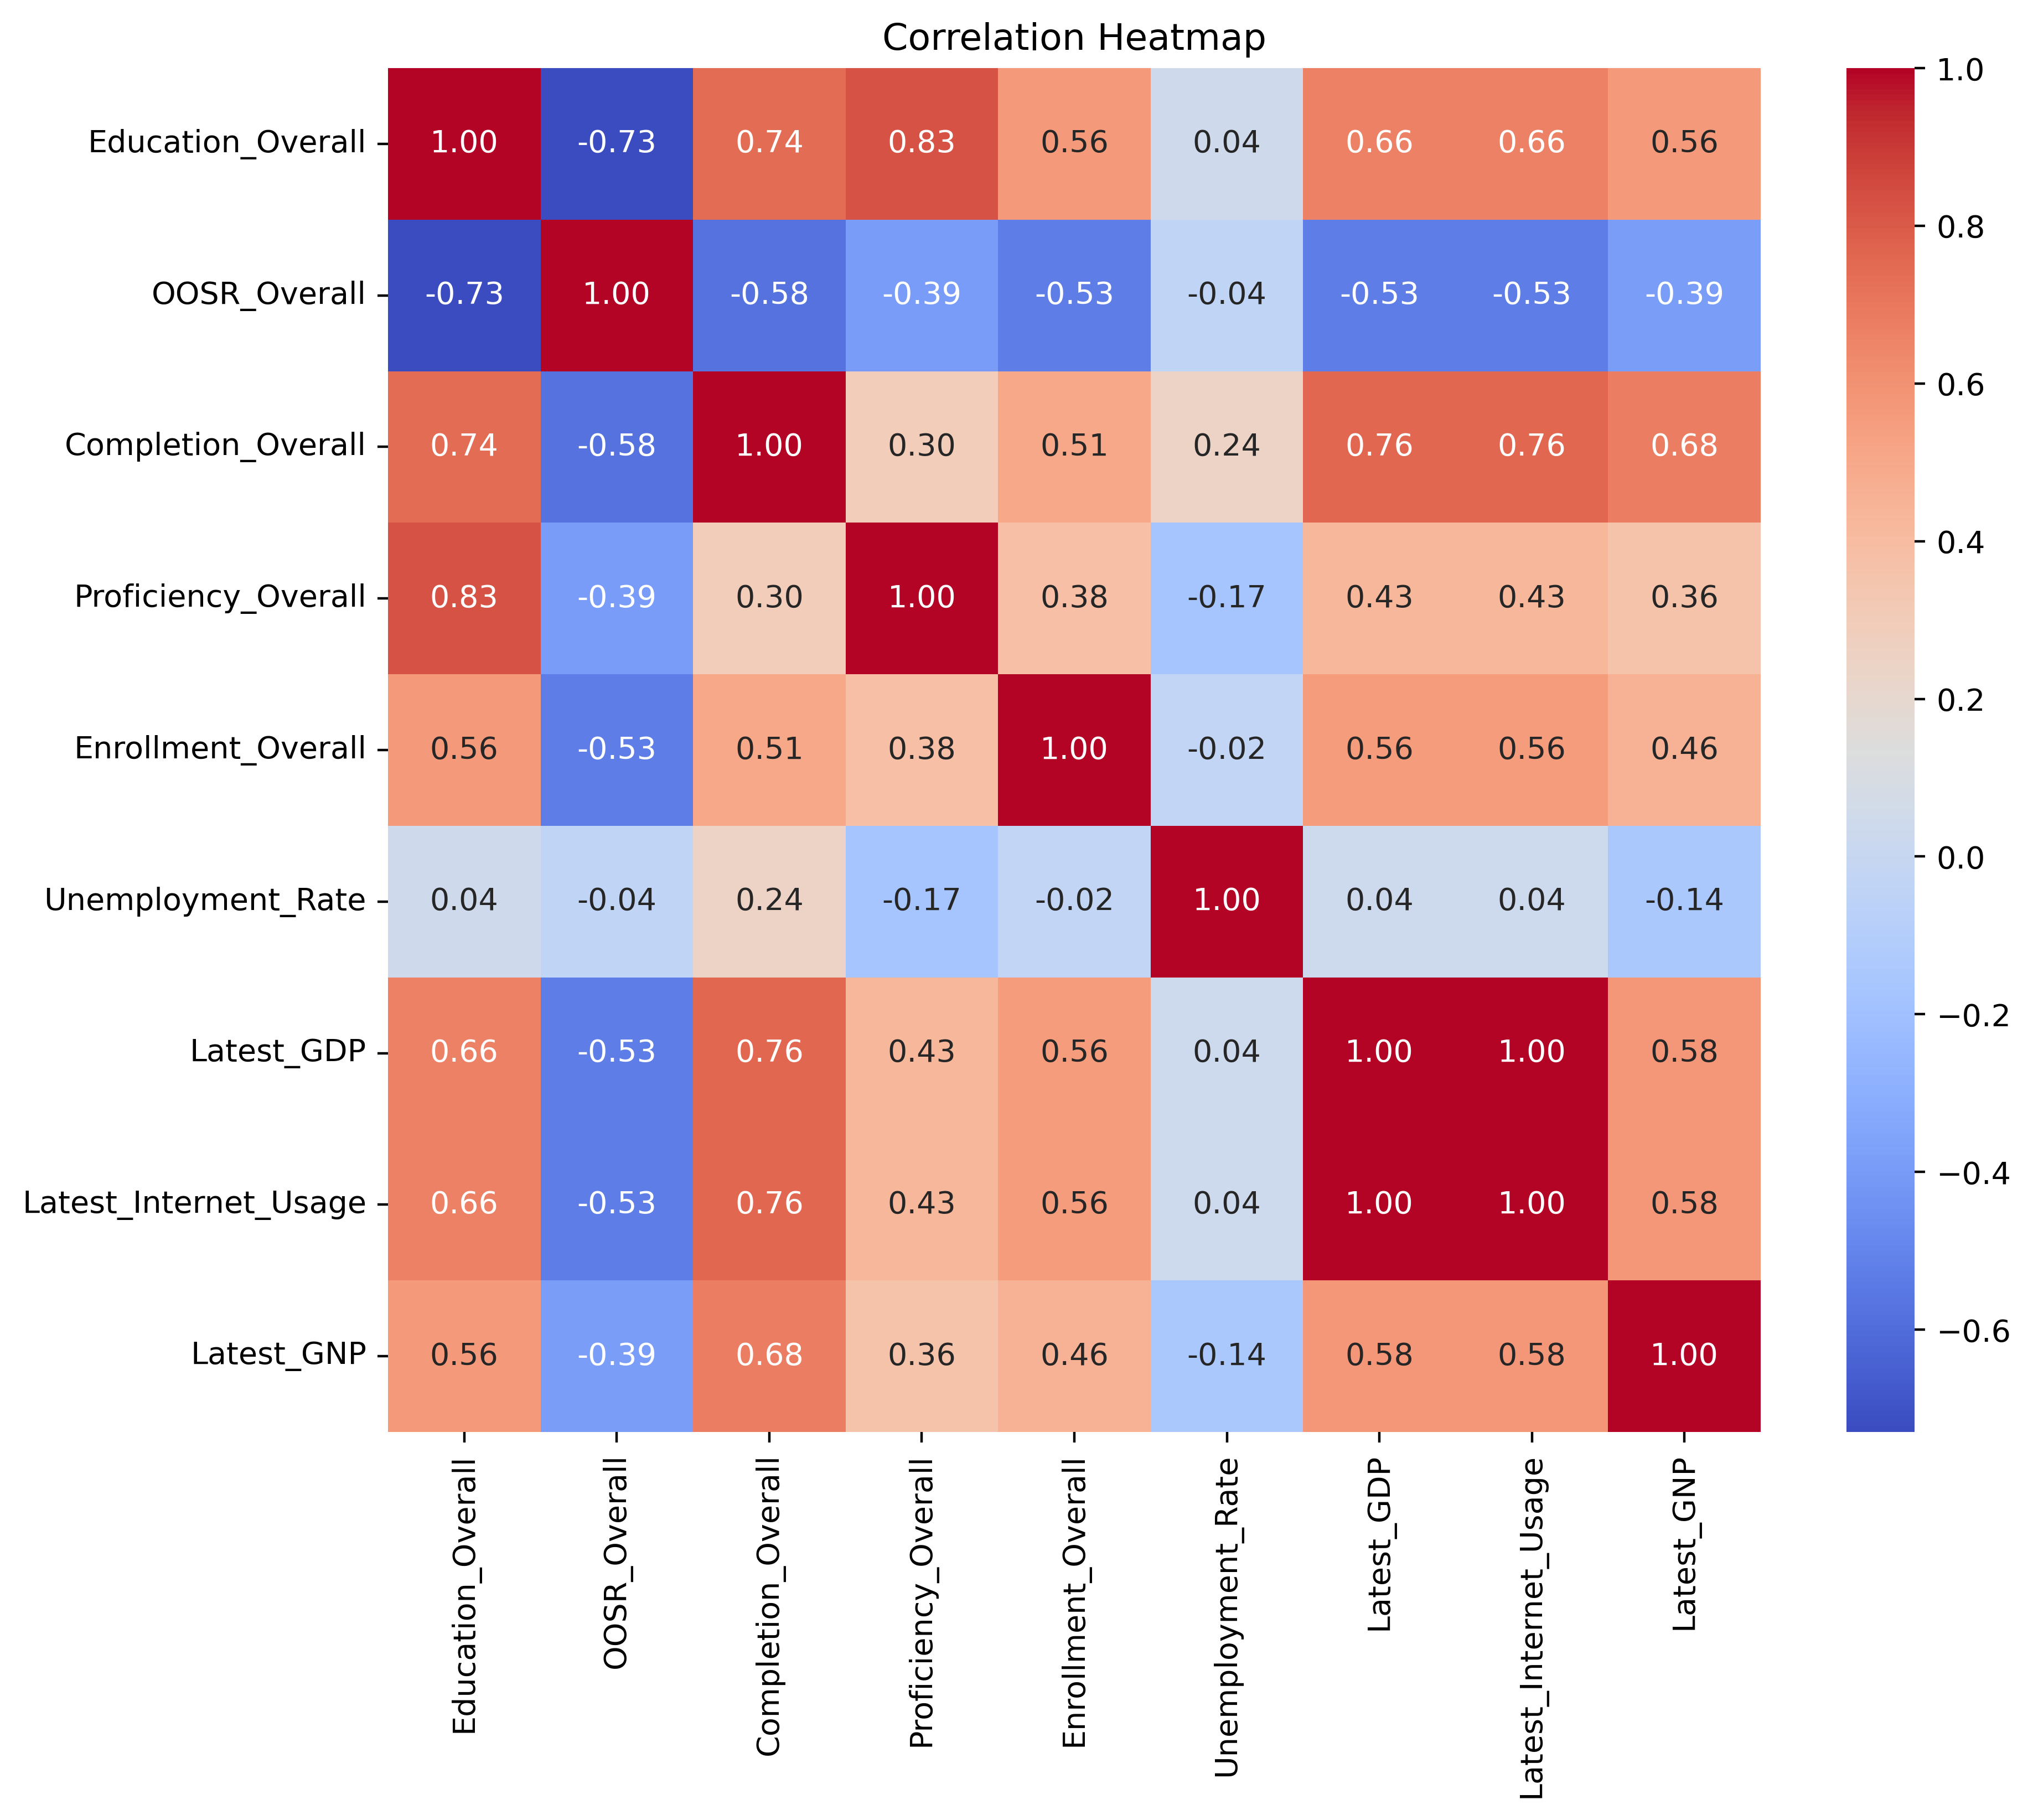

In [4]:
#plot the correlation matrix
correlation=df[education_cols+scocioeconomy_columns].corr()
plt.figure(figsize=(10, 8),dpi=400)
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()